In [ ]:
# Standard libraries
import sys
import os

# Astro imports
import sunpy.map

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sunpy.map
import sunpy.data
import sunpy.net
from sunpy.net import Fido, attrs as a
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MeanShift
from skimage.feature import canny
from skimage.transform import rescale

from sklearn.model_selection import RandomizedSearchCV

# Asegurarse de que el directorio correcto está añadido a sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import (
    progress_bar,
    logger,
    format_time,
)

In [2]:
# Definir la ruta a la carpeta donde están los archivos .fits
data_path = "../Data/SDO_data"  # Subir un nivel y entrar a la carpeta Data
# Obtener todas las imágenes FITS dentro del rango de tiempo
fits_files = sorted([f for f in os.listdir(data_path) if f.endswith('.fits')])

In [3]:
# Verificar si la carpeta existe y listar los archivos .fits
if os.path.exists(data_path):
    fits_files = [f for f in os.listdir(data_path) if f.endswith('.fits')]
    print(f"Archivos .fits encontrados: {len(fits_files)}")
else:
    print(f"La ruta {data_path} no existe.")

Archivos .fits encontrados: 900


In [4]:
log = logger(True) ; log("logging in :)") 
log("This is a test log message.")

# Auto-reloading of modules in iPython
%load_ext autoreload
%autoreload 2

logging in :)
This is a test log message.


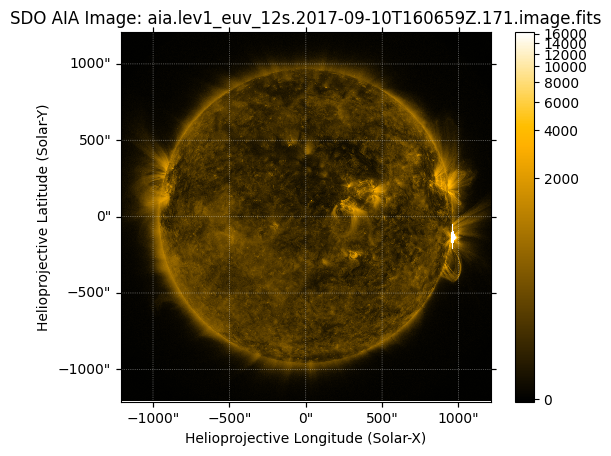

In [5]:
# Cargar uno de los archivos .fits
if fits_files:
    first_fits_file = os.path.join(data_path, fits_files[0])
    
    # Cargar el archivo FITS usando sunpy
    solar_map = sunpy.map.Map(first_fits_file)
    
    # Visualizar la imagen
    plt.figure()
    solar_map.plot()
    plt.colorbar()
    plt.title(f"SDO AIA Image: {fits_files[0]}")
    plt.show()
else:
    print("No se encontraron archivos .fits.")

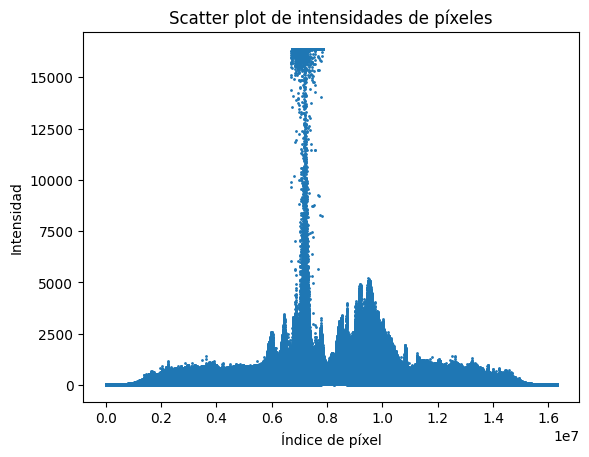

In [6]:
# Extraer los valores de los píxeles para el análisis
pixel_values = solar_map.data.flatten()

# Crear un gráfico de dispersión para las intensidades de los píxeles
plt.figure()
plt.scatter(range(len(pixel_values)), pixel_values, s=1)
plt.title("Scatter plot de intensidades de píxeles")
plt.xlabel("Índice de píxel")
plt.ylabel("Intensidad")
plt.show()

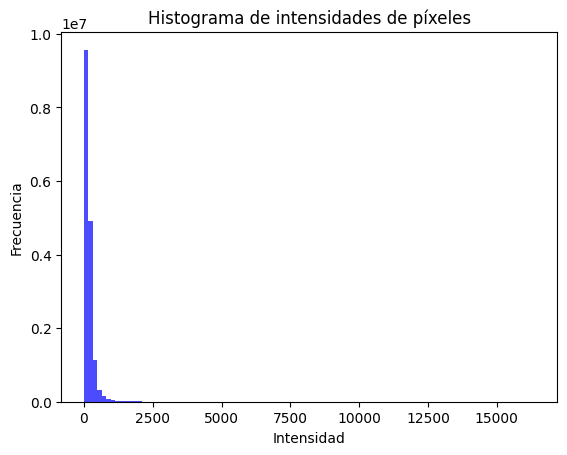

Intensidad media: 163.5786895751953
Desviación estándar: 385.81689453125
Intensidad mínima: -6.0
Intensidad máxima: 16383.0


In [7]:

# Crear un histograma de las intensidades de los píxeles
plt.figure()
plt.hist(pixel_values, bins=100, color='blue', alpha=0.7)
plt.title("Histograma de intensidades de píxeles")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.show()

# Mostrar algunas estadísticas básicas
print(f"Intensidad media: {pixel_values.mean()}")
print(f"Desviación estándar: {pixel_values.std()}")
print(f"Intensidad mínima: {pixel_values.min()}")
print(f"Intensidad máxima: {pixel_values.max()}")

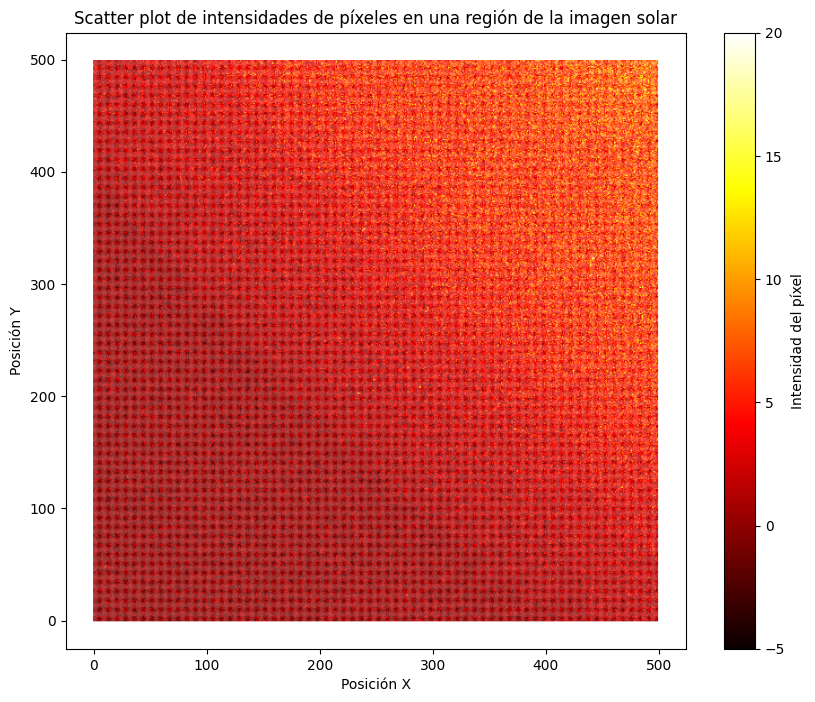

In [8]:
# Extraer una sección de la imagen (por ejemplo, una región de 500x500 píxeles)
region_size = 500
x_start, y_start = 100, 100  # Ajusta estos valores según la región que quieras procesar
region = solar_map.data[x_start:x_start + region_size, y_start:y_start + region_size]

# Crear los valores X y Y para la región seleccionada
X_region, Y_region = np.meshgrid(np.arange(region_size), np.arange(region_size))
intensity_region = region.flatten()

# Normalización de los datos de intensidad
scaler = StandardScaler()
intensity_region_scaled = scaler.fit_transform(intensity_region.reshape(-1, 1))

# Scatter plot de la región seleccionada
plt.figure(figsize=(10, 8))
plt.scatter(X_region.flatten(), Y_region.flatten(), c=intensity_region, cmap='hot', s=1, edgecolor='none')
plt.colorbar(label='Intensidad del píxel')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.title('Scatter plot de intensidades de píxeles en una región de la imagen solar')
plt.show()


# Sleecion conveniente de una region solar - flare a las 16:00 

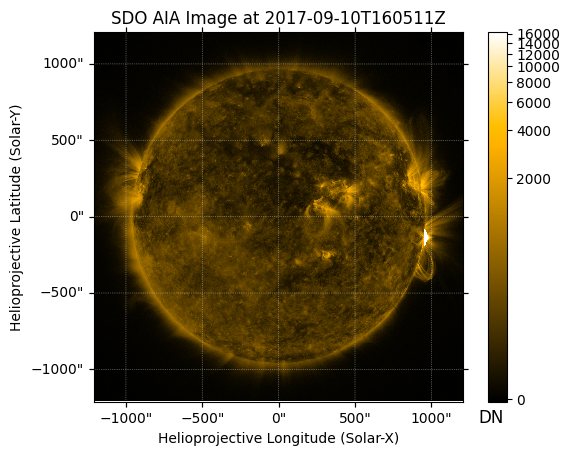

In [9]:
# Especificar la fecha y hora de interés
specific_time = "2017-09-10T160511Z"  # Fecha y hora exactas de la imagen deseada
# Buscar el archivo .fits que coincida con la hora específica
fits_file = next((f for f in os.listdir(data_path) if specific_time in f), None)

# Cargar la imagen FITS si el archivo específico es encontrado
if fits_file:
    fits_path = os.path.join(data_path, fits_file)
    solar_map = sunpy.map.Map(fits_path, allow_errors=True)
    
    # Visualizar la imagen con un título que indique la fecha y hora
    solar_map.peek(title=f"SDO AIA Image at {specific_time}")
else:
    print(f"No se encontró el archivo FITS para {specific_time}")


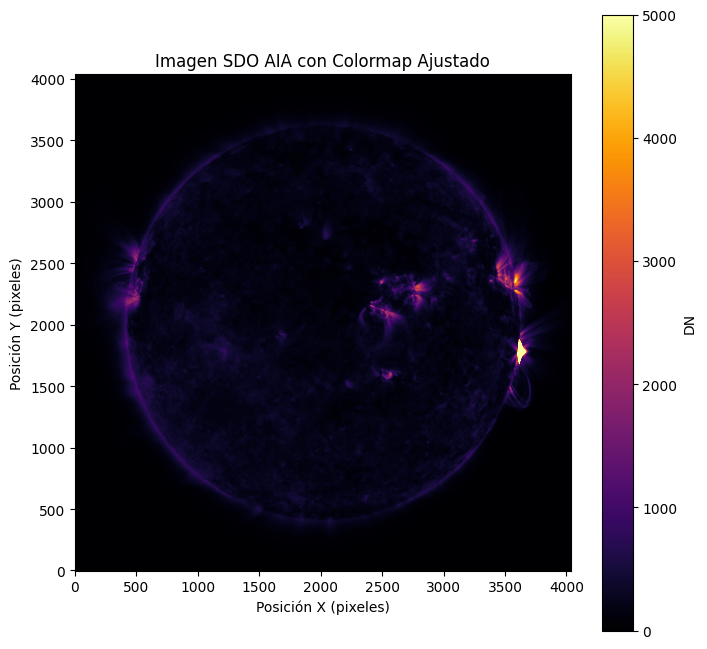

In [10]:
import matplotlib.pyplot as plt

# Mostrar la imagen con un colormap ajustado y límites de color
plt.figure(figsize=(8, 8))
plt.imshow(solar_map.data, cmap='inferno', origin='lower', vmin=0, vmax=5000)  # Ajusta vmin y vmax según el contraste deseado
plt.colorbar(label="DN")  # Agrega una barra de color para la intensidad
plt.xlabel("Posición X (pixeles)")
plt.ylabel("Posición Y (pixeles)")
plt.title("Imagen SDO AIA con Colormap Ajustado")
plt.show()


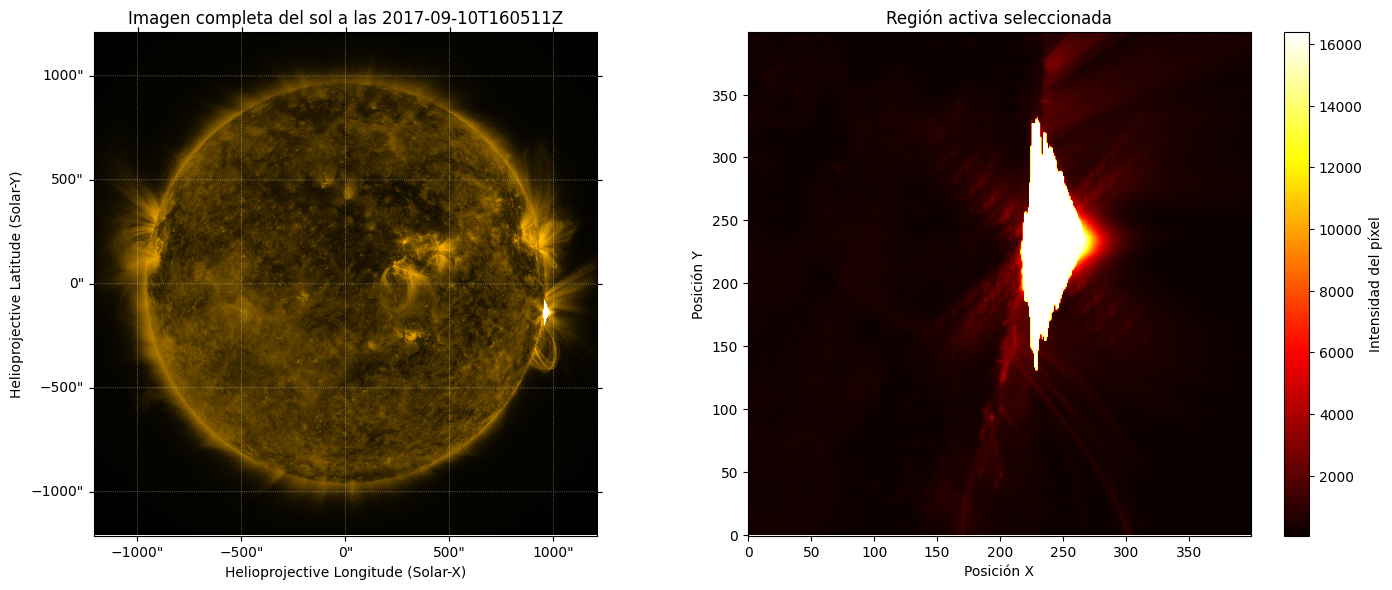

In [11]:
from astropy.visualization.wcsaxes import WCSAxes
# Definir la región de interés
x_start, y_start = 3380, 1550  # Coordenadas ajustadas para la región exacta
region_size = 400  # Ajuste para el tamaño de la región activa
region_img2 = solar_map.data[y_start:y_start + region_size, x_start:x_start + region_size]

# Crear la visualización con subplots y definir la proyección WCS para la imagen completa
fig = plt.figure(figsize=(15, 6))

# Subplot para la imagen completa con proyección WCS
ax1 = fig.add_subplot(1, 2, 1, projection=solar_map.wcs)
solar_map.plot(axes=ax1, title=f"SDO AIA Image at {specific_time}")
ax1.set_title(f"Imagen completa del sol a las {specific_time}")

# Subplot para la región activa
ax2 = fig.add_subplot(1, 2, 2)
im = ax2.imshow(region_img2, cmap='hot', origin='lower')
ax2.set_title("Región activa seleccionada")
ax2.set_xlabel("Posición X")
ax2.set_ylabel("Posición Y")
plt.colorbar(im, ax=ax2, label="Intensidad del píxel")

plt.tight_layout()
plt.show()


In [12]:
# Preprocesamiento de los datos de intensidad (normalización)
scaler = StandardScaler()
intensity_region_scaled = scaler.fit_transform(region_img2.reshape(-1, 1))

In [ ]:
# Definir el rango de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_samples': [100, 'auto', 0.75],
    'contamination': [0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5],
}
iso_forest = IsolationForest(random_state=42)

def custom_score(estimator, X):
    scores = estimator.score_samples(X)
    return np.mean(scores)
# Meetrica para optimizar
random_search = RandomizedSearchCV(estimator=iso_forest, param_distributions=param_dist, 
                                   n_iter=10, cv=5, verbose=1, n_jobs=-1,
                                   scoring=custom_score)
random_search.fit(intensity_region_scaled)
print(f"Mejores parámetros: {random_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros: {'n_estimators': 50, 'max_samples': 'auto', 'max_features': 1.0, 'contamination': 0.2}


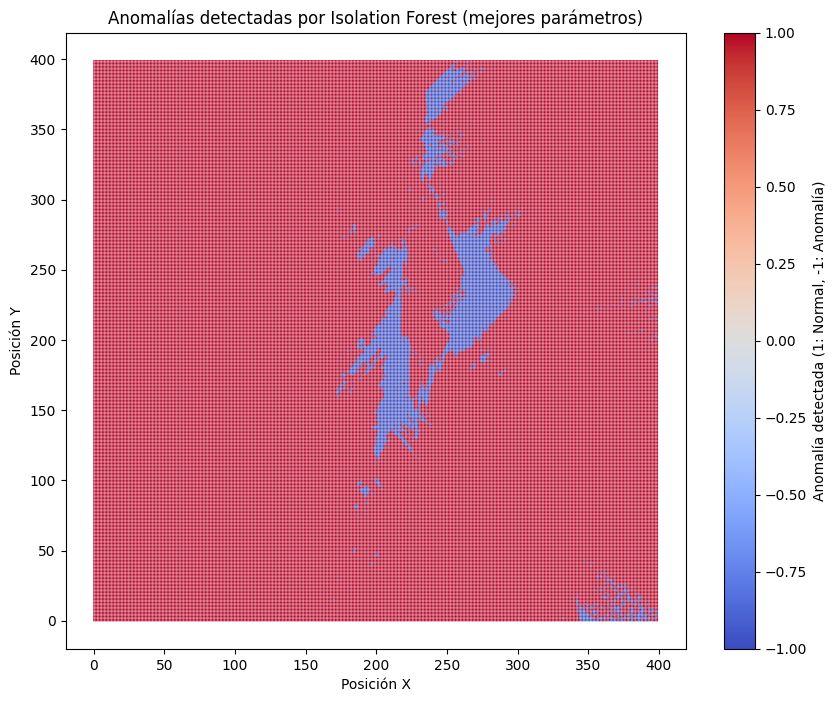

Número de anomalías detectadas con los mejores parámetros: 7998


In [14]:
# Crear el modelo Isolation Forest con los mejores parámetros
best_iso_forest = IsolationForest(
    n_estimators=150, 
    max_samples=0.75, 
    max_features=0.5, 
    contamination=0.05, 
    random_state=42
)

# Entrenar el modelo con los datos escalados
best_iso_forest.fit(intensity_region_scaled)

# Predecir anomalías
best_anomaly_labels = best_iso_forest.predict(intensity_region_scaled)

# Visualizar las anomalías detectadas en la región seleccionada
X_region, Y_region = np.meshgrid(np.arange(region_size), np.arange(region_size))

plt.figure(figsize=(10, 8))
plt.scatter(X_region.flatten(), Y_region.flatten(), c=best_anomaly_labels, cmap='coolwarm', s=1, edgecolor='none')
plt.colorbar(label='Anomalía detectada (1: Normal, -1: Anomalía)')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.title('Anomalías detectadas por Isolation Forest (mejores parámetros)')
plt.show()

# Contar el número de anomalías detectadas
n_best_anomalies = np.sum(best_anomaly_labels == -1)
print(f'Número de anomalías detectadas con los mejores parámetros: {n_best_anomalies}')

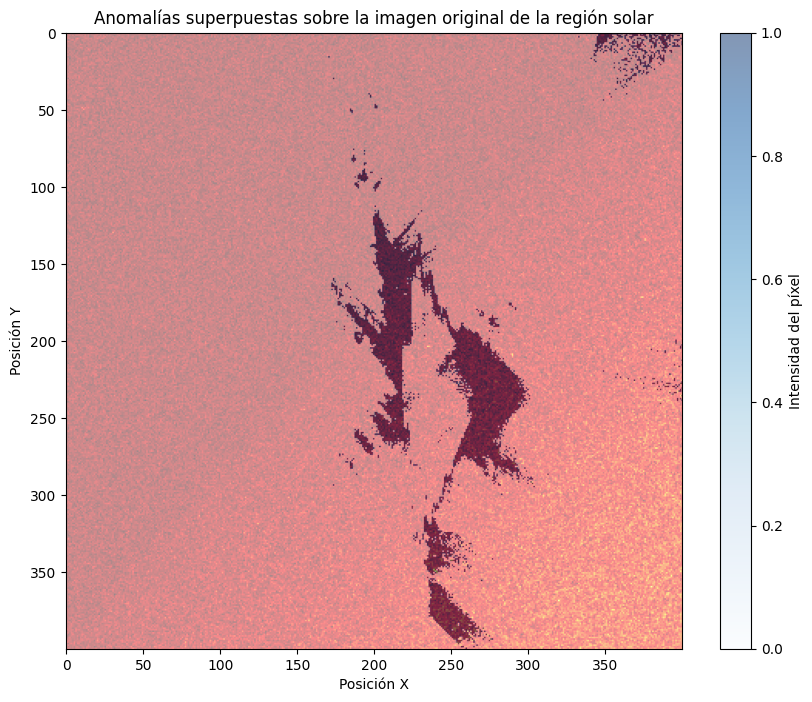

In [15]:
# Crear una copia de la región de la imagen solar para superponer las anomalías
solar_map_with_anomalies = np.copy(region)

# Poner las anomalías (píxeles etiquetados como -1) en la imagen original
anomalous_pixels = (best_anomaly_labels == -1).reshape(region_size, region_size)

# Superponer las anomalías en la imagen original (píxeles anómalos en color azul)
plt.figure(figsize=(10, 8))
plt.imshow(solar_map_with_anomalies, cmap='hot', origin='lower', alpha=0.9)
plt.imshow(anomalous_pixels, cmap='Blues', alpha=0.5)  # Anomalías en azul
plt.colorbar(label='Intensidad del píxel')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.title('Anomalías superpuestas sobre la imagen original de la región solar')
plt.show()


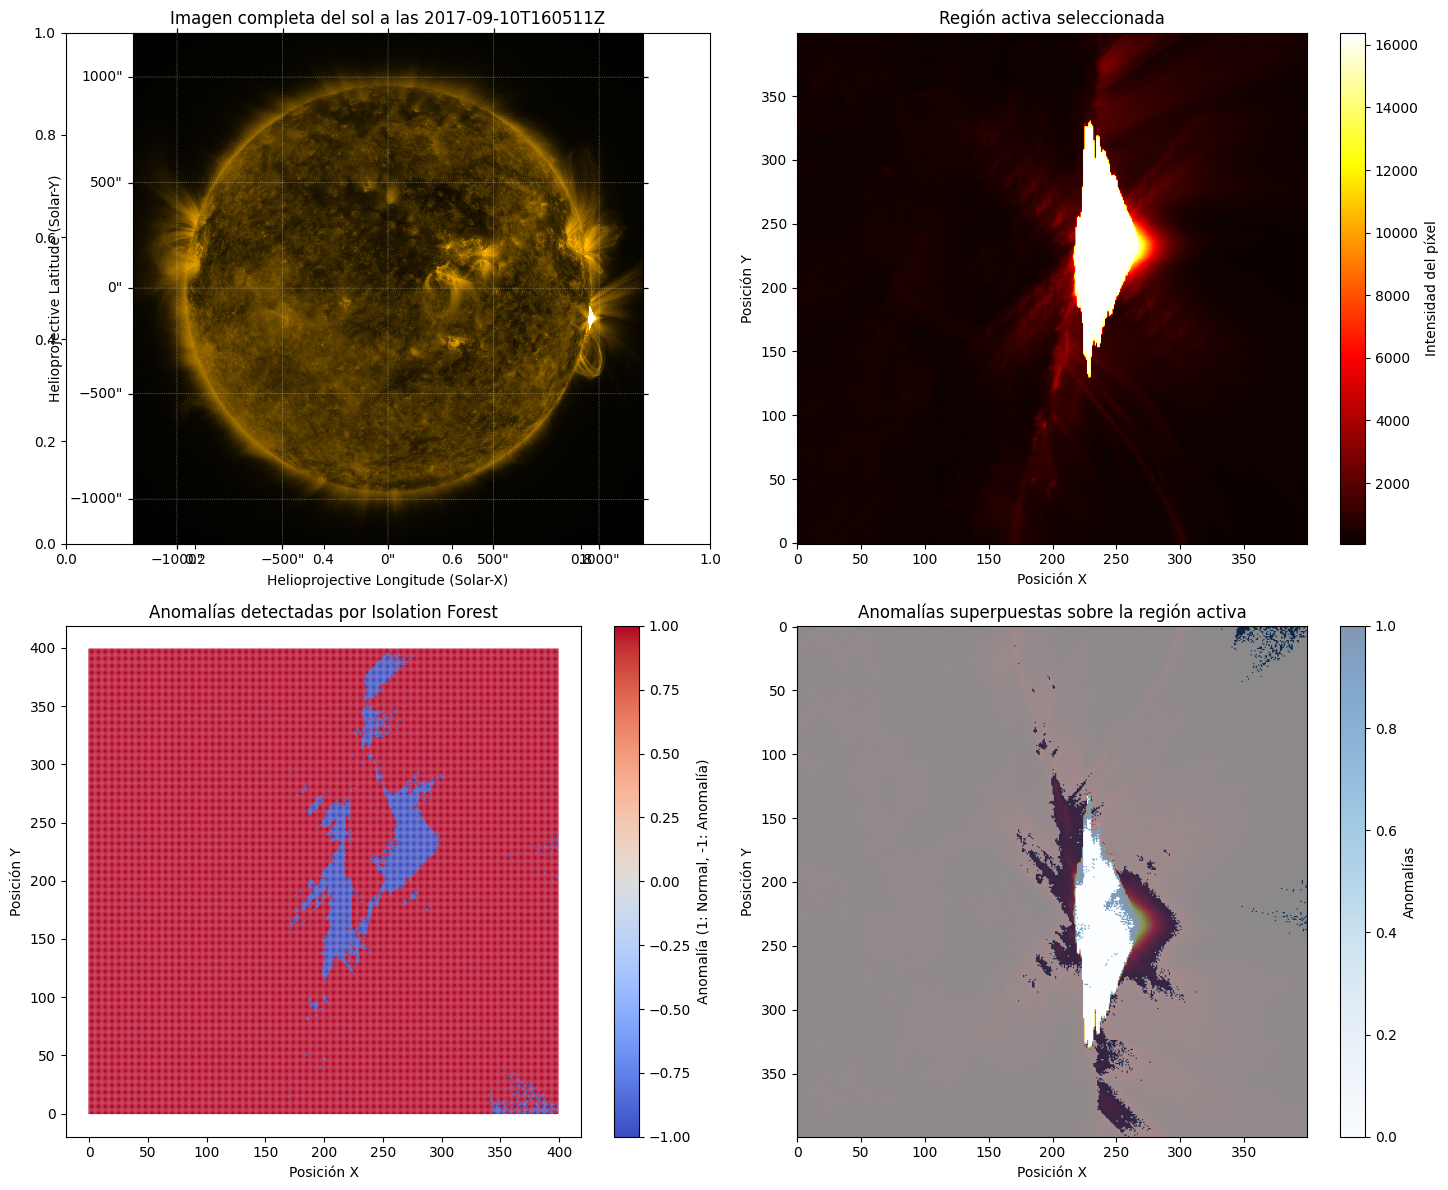

In [16]:
# Crear figura y cuadrícula de 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Imagen completa con proyección WCS
ax1 = fig.add_subplot(2, 2, 1, projection=solar_map.wcs)
solar_map.plot(axes=ax1, title=f"SDO AIA Image at {specific_time}")
ax1.set_title(f"Imagen completa del sol a las {specific_time}")

# Subplot 2: Región activa seleccionada
region_img2 = solar_map.data[y_start:y_start + region_size, x_start:x_start + region_size]
im1 = axs[0, 1].imshow(region_img2, cmap='hot', origin='lower')
axs[0, 1].set_title("Región activa seleccionada")
axs[0, 1].set_xlabel("Posición X")
axs[0, 1].set_ylabel("Posición Y")
plt.colorbar(im1, ax=axs[0, 1], label="Intensidad del píxel")

# Subplot 3: Mapa de anomalías en la región seleccionada
X_region, Y_region = np.meshgrid(np.arange(region_size), np.arange(region_size))
axs[1, 0].scatter(X_region.flatten(), Y_region.flatten(), c=best_anomaly_labels, cmap='coolwarm', s=1, edgecolor='none')
axs[1, 0].set_title('Anomalías detectadas por Isolation Forest')
axs[1, 0].set_xlabel('Posición X')
axs[1, 0].set_ylabel('Posición Y')
plt.colorbar(axs[1, 0].collections[0], ax=axs[1, 0], label='Anomalía (1: Normal, -1: Anomalía)')

# Subplot 4: Superposición de anomalías en la imagen original de la región activa
anomalous_pixels = (best_anomaly_labels == -1).reshape(region_size, region_size)
axs[1, 1].imshow(region_img2, cmap='hot', origin='lower', alpha=0.9)
im2 = axs[1, 1].imshow(anomalous_pixels, cmap='Blues', alpha=0.5)
axs[1, 1].set_title('Anomalías superpuestas sobre la región activa')
axs[1, 1].set_xlabel("Posición X")
axs[1, 1].set_ylabel("Posición Y")
plt.colorbar(im2, ax=axs[1, 1], label="Anomalías")

plt.tight_layout()
plt.show()


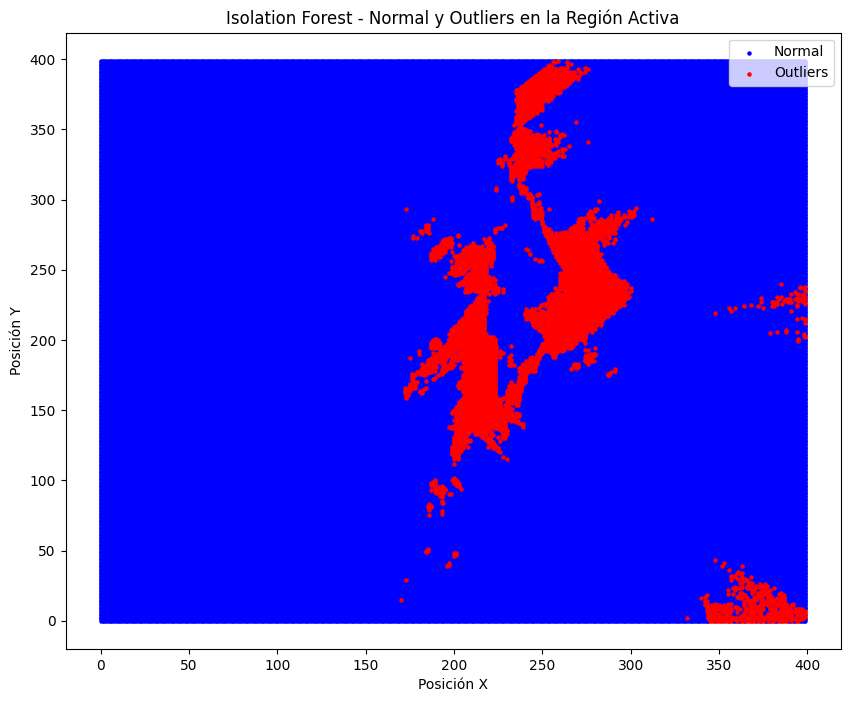

In [16]:
# Crear una cuadrícula de coordenadas X e Y para la región seleccionada
X_region, Y_region = np.meshgrid(np.arange(region_size), np.arange(region_size))

# Filtrar los puntos normales y anómalos usando las etiquetas
normales_x = X_region[best_anomaly_labels.reshape(region_size, region_size) == 1]
normales_y = Y_region[best_anomaly_labels.reshape(region_size, region_size) == 1]
anomalos_x = X_region[best_anomaly_labels.reshape(region_size, region_size) == -1]
anomalos_y = Y_region[best_anomaly_labels.reshape(region_size, region_size) == -1]

# Graficar los puntos normales y anómalos
plt.figure(figsize=(10, 8))
plt.scatter(normales_x, normales_y, c="blue", marker="o", label="Normal", s=5)
plt.scatter(anomalos_x, anomalos_y, c="red", marker="o", label="Outliers", s=5)
plt.xlabel("Posición X")
plt.ylabel("Posición Y")
plt.title("Isolation Forest - Normal y Outliers en la Región Activa")
plt.legend()
plt.show()


## Generar mas features gradientesw 

In [17]:
from scipy.ndimage import sobel

# Calcula el gradiente en X e Y en la región seleccionada
grad_x = sobel(region_img2, axis=1)
grad_y = sobel(region_img2, axis=0)

# Normaliza los gradientes
grad_x_scaled = scaler.fit_transform(grad_x.reshape(-1, 1))
grad_y_scaled = scaler.fit_transform(grad_y.reshape(-1, 1))

# Añade los gradientes como nuevas características
features = np.hstack([intensity_region_scaled, grad_x_scaled, grad_y_scaled])


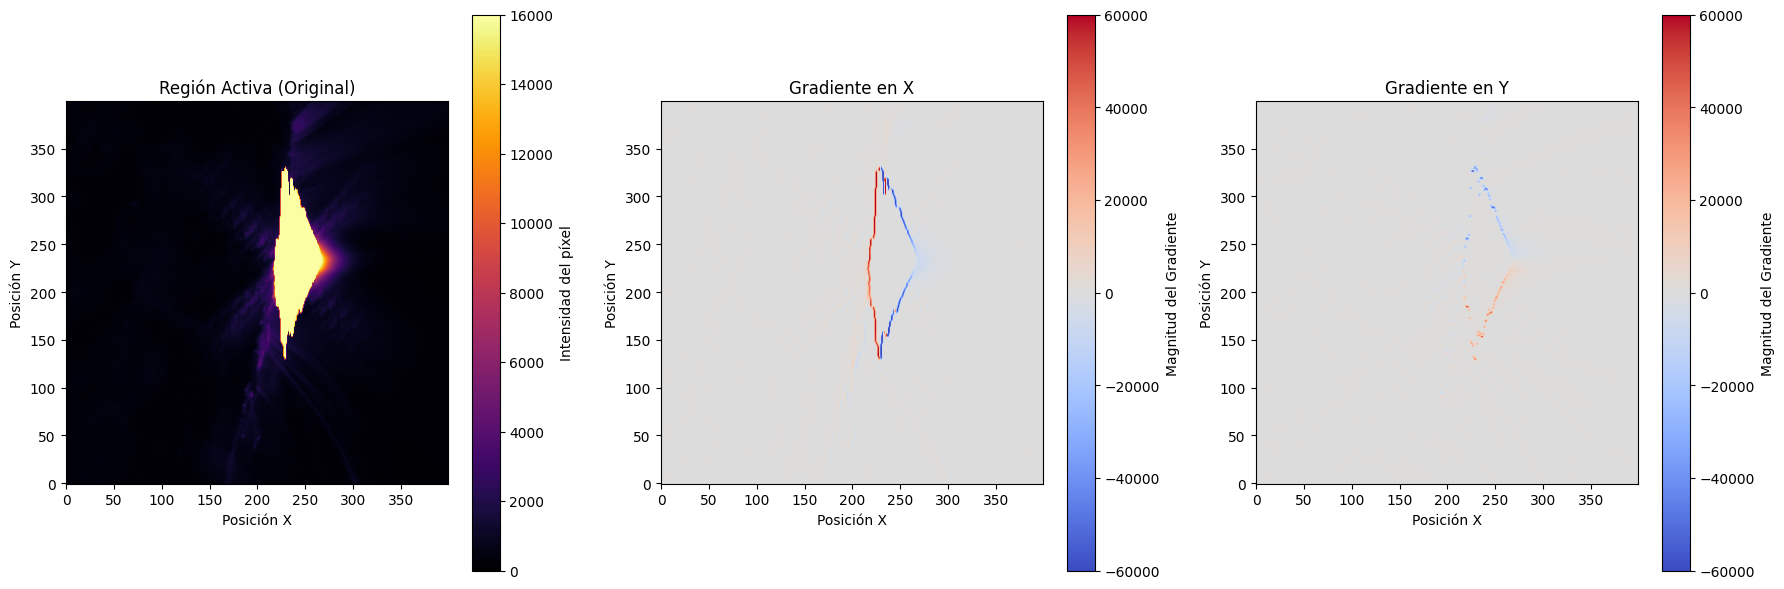

In [18]:
# Configuración de la figura y los subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot de la región original
im0 = axes[0].imshow(region_img2, cmap='inferno', origin='lower', vmin=0, vmax=16000)  # Ajusta vmin y vmax según la intensidad deseada
axes[0].set_title("Región Activa (Original)")
axes[0].set_xlabel("Posición X")
axes[0].set_ylabel("Posición Y")
plt.colorbar(im0, ax=axes[0], label='Intensidad del píxel')

# Plot del gradiente en X
im1 = axes[1].imshow(grad_x, cmap='coolwarm', origin='lower', vmin=-60000, vmax=60000)  # Ajuste de rango de gradiente
axes[1].set_title("Gradiente en X")
axes[1].set_xlabel("Posición X")
axes[1].set_ylabel("Posición Y")
plt.colorbar(im1, ax=axes[1], label='Magnitud del Gradiente')

# Plot del gradiente en Y
im2 = axes[2].imshow(grad_y, cmap='coolwarm', origin='lower', vmin=-60000, vmax=60000)  # Ajuste de rango de gradiente
axes[2].set_title("Gradiente en Y")
axes[2].set_xlabel("Posición X")
axes[2].set_ylabel("Posición Y")
plt.colorbar(im2, ax=axes[2], label='Magnitud del Gradiente')

# Ajuste del layout
plt.tight_layout()
plt.show()


## Clustering

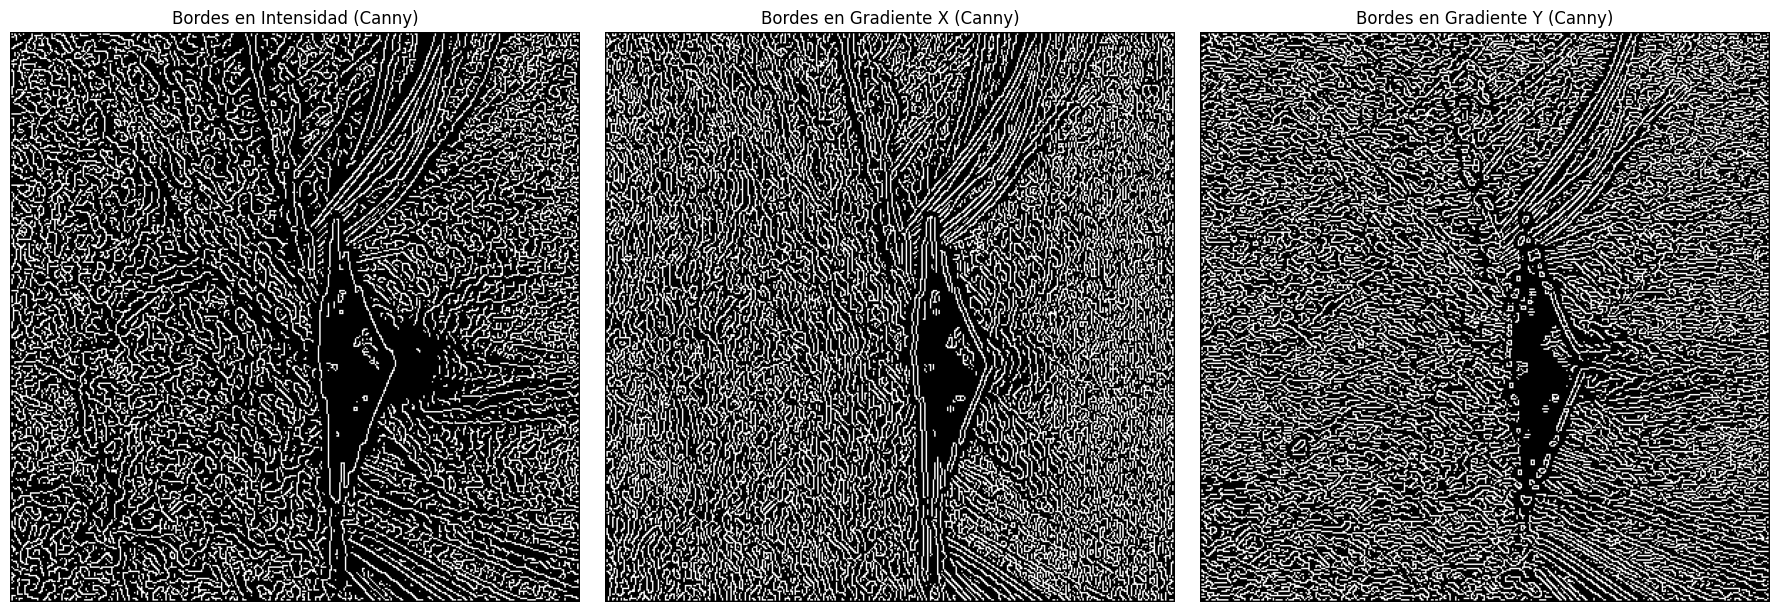

In [19]:
from skimage import feature
import matplotlib.pyplot as plt

# Aplicar el filtro de Canny sobre la región original y los gradientes
canny_edges_intensity = feature.canny(region_img2, sigma=1)
canny_edges_grad_x = feature.canny(grad_x, sigma=1)
canny_edges_grad_y = feature.canny(grad_y, sigma=1)

# Visualizar los resultados del filtro de Canny
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(canny_edges_intensity, cmap='gray')
axs[0].set_title("Bordes en Intensidad (Canny)")
axs[1].imshow(canny_edges_grad_x, cmap='gray')
axs[1].set_title("Bordes en Gradiente X (Canny)")
axs[2].imshow(canny_edges_grad_y, cmap='gray')
axs[2].set_title("Bordes en Gradiente Y (Canny)")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


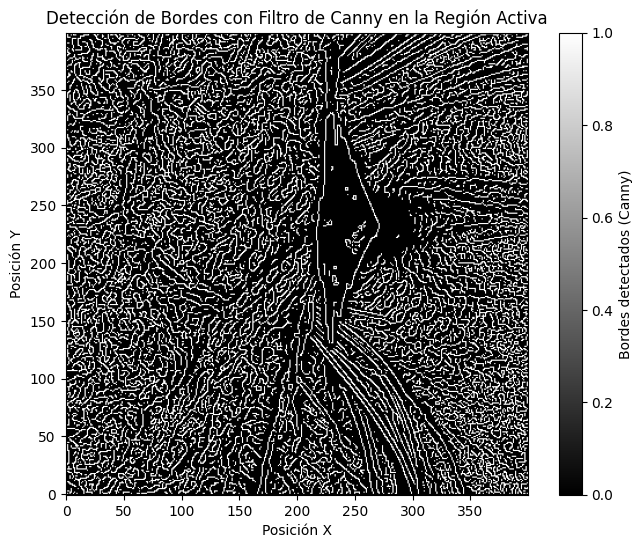

In [20]:
import matplotlib.pyplot as plt

# Aplicación del filtro de Canny en la región original
from skimage.feature import canny

# Aplicar el filtro de Canny
edges = canny(region_img2, sigma=1.0)  # Ajusta sigma según sea necesario

# Crear la visualización
plt.figure(figsize=(8, 6))

# Mostrar los bordes detectados
plt.imshow(edges, cmap='gray', origin='lower')
plt.colorbar(label="Bordes detectados (Canny)")
plt.title("Detección de Bordes con Filtro de Canny en la Región Activa")
plt.xlabel("Posición X")
plt.ylabel("Posición Y")
plt.show()



# Definicion de las features y usasmos Meanshift

In [19]:
from sklearn.cluster import MeanShift

# Usar la intensidad y los gradientes como características de entrada
features = np.hstack([intensity_region_scaled, grad_x_scaled, grad_y_scaled])

# Aplicar Mean Shift
mean_shift = MeanShift(bandwidth=1.0)  # Ajustar el parámetro de bandwidth según sea necesario
mean_shift.fit(features)

# Obtener las etiquetas de los clústeres
cluster_labels = mean_shift.labels_

KeyboardInterrupt: 

In [ ]:
#plot MeanShift
plt.figure(figsize=(10, 8))
plt.scatter(X_region.flatten(), Y_region.flatten(), c=cluster_labels, cmap='plasma', s=5, edgecolor='none')  # Ajuste del cmap y tamaño de los puntos
plt.colorbar(label='Etiqueta del Clúster')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.title('Clustering de Mean Shift en la Región Activa')
plt.show()


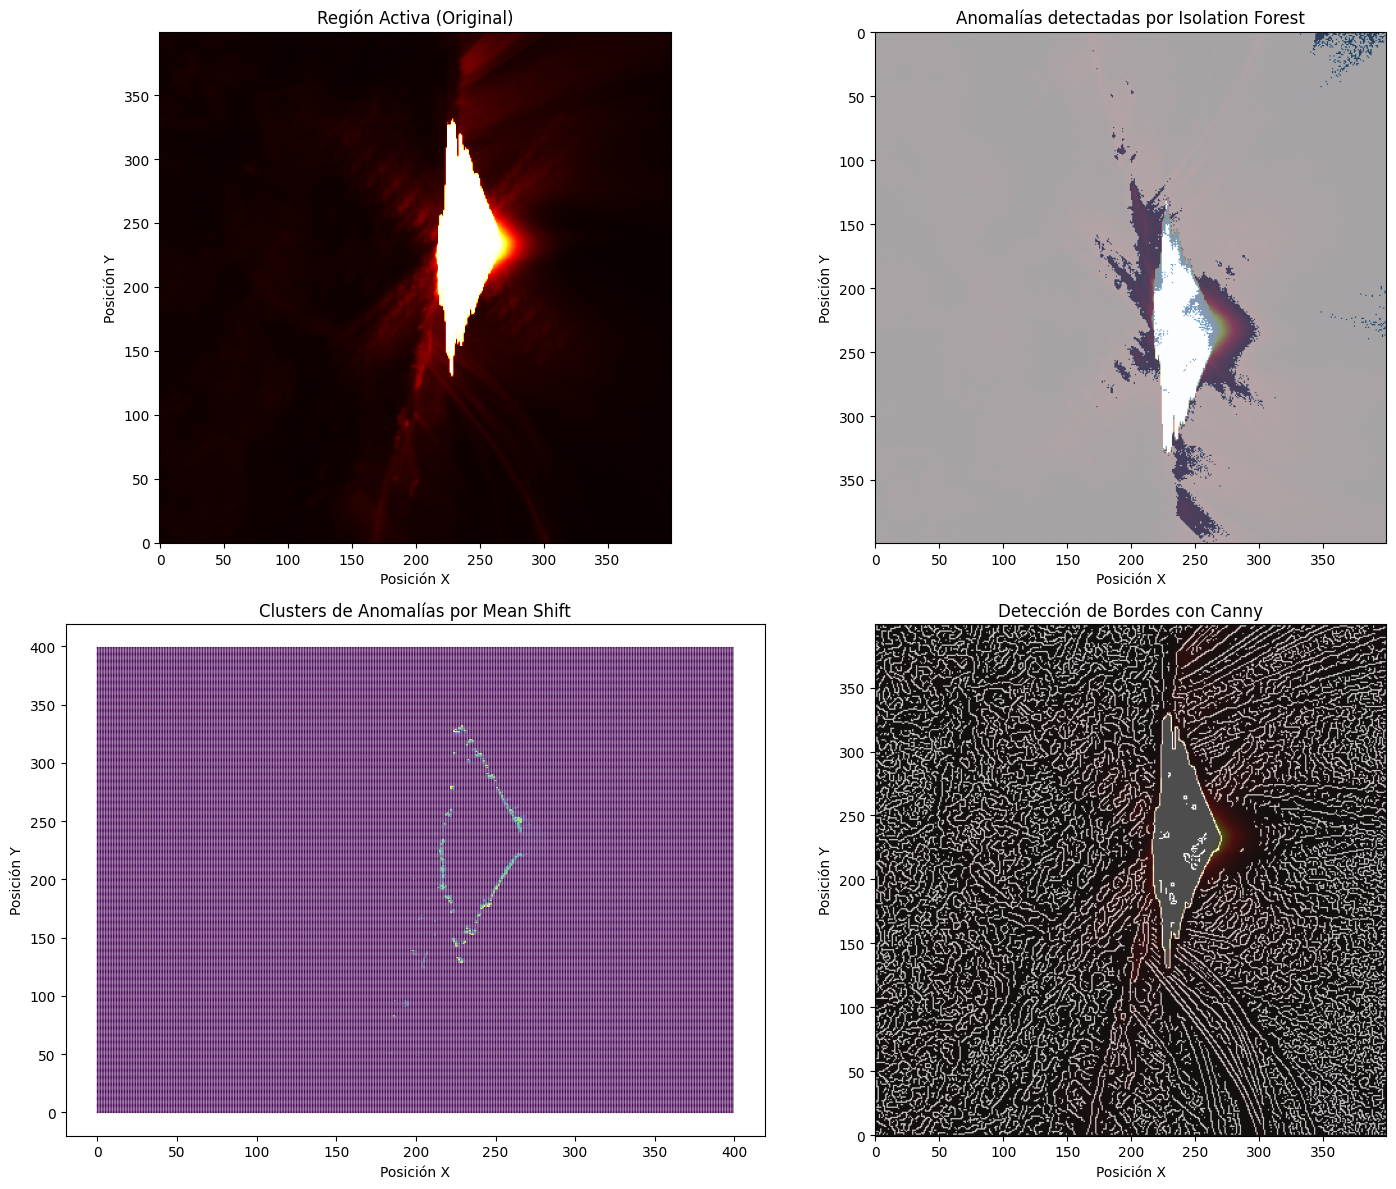

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Imagen original de la región activa
axs[0, 0].imshow(region_img2, cmap='hot', origin='lower')
axs[0, 0].set_title("Región Activa (Original)")
axs[0, 0].set_xlabel("Posición X")
axs[0, 0].set_ylabel("Posición Y")

# Subplot 2: Anomalías detectadas con Isolation Forest
anomaly_mask = best_anomaly_labels.reshape(region_size, region_size) == -1
axs[0, 1].imshow(region_img2, cmap='hot', origin='lower', alpha=0.7)
axs[0, 1].imshow(anomaly_mask, cmap='Blues', alpha=0.5)
axs[0, 1].set_title("Anomalías detectadas por Isolation Forest")
axs[0, 1].set_xlabel("Posición X")
axs[0, 1].set_ylabel("Posición Y")

# Subplot 3: Clusters de anomalías con Mean Shift
axs[1, 0].scatter(X_region.flatten(), Y_region.flatten(), c=cluster_labels, cmap='viridis', s=1, edgecolor='none')
axs[1, 0].set_title("Clusters de Anomalías por Mean Shift")
axs[1, 0].set_xlabel("Posición X")
axs[1, 0].set_ylabel("Posición Y")

# Subplot 4: Bordes detectados con Canny
axs[1, 1].imshow(region_img2, cmap='hot', origin='lower', alpha=0.8)
axs[1, 1].imshow(edges, cmap='gray', origin='lower', alpha=0.7)
axs[1, 1].set_title("Detección de Bordes con Canny")
axs[1, 1].set_xlabel("Posición X")
axs[1, 1].set_ylabel("Posición Y")

plt.tight_layout()
plt.show()


# ceVAE - Propuesta articulo.


- Entrenar el modelo ceVAE con la imagen completa para que pueda aprender a reconstruir las regiones normales y detectar anomalías en las áreas donde la reconstrucción sea mal.

Utilizamos un autoencoder simple para reducir la dimensionalidad de las características de intensidad y gradiente (X e Y) en un espacio latente compacto.

Prepare data, recordar que el poposito de esto es enviar todo a ese espacio latente que creamos en el auencoder antterior

Train de model

Anomaly detection

Step 5: Clustering and Edge Detection on Anomaly Regions

Epoch 1, Loss: 1.6124352666378021
Epoch 2, Loss: 1.6096231410503388
Epoch 3, Loss: 1.6091495445251465
Epoch 4, Loss: 1.609062229013443
Epoch 5, Loss: 1.6088441716194153
Epoch 6, Loss: 1.6087764885425568
Epoch 7, Loss: 1.608634939622879
Epoch 8, Loss: 1.6086496576309204
Epoch 9, Loss: 1.608538972568512
Epoch 10, Loss: 1.6084846050262451
Epoch 11, Loss: 1.608443948316574
Epoch 12, Loss: 1.608497152519226
Epoch 13, Loss: 1.6084277428150178
Epoch 14, Loss: 1.6083698186397553
Epoch 15, Loss: 1.608294262123108
Epoch 16, Loss: 1.608449112701416
Epoch 17, Loss: 1.6083643777370453
Epoch 18, Loss: 1.6083521581172944
Epoch 19, Loss: 1.6082723884105683
Epoch 20, Loss: 1.6082786033153533
Epoch 21, Loss: 1.6083566539287568
Epoch 22, Loss: 1.608256976556778
Epoch 23, Loss: 1.60831629447937
Epoch 24, Loss: 1.6083095641613006
Epoch 25, Loss: 1.6082784772872925
Epoch 26, Loss: 1.608287019109726
Epoch 27, Loss: 1.6082511768341063
Epoch 28, Loss: 1.6082266233921052
Epoch 29, Loss: 1.6082320791244507
Epoch

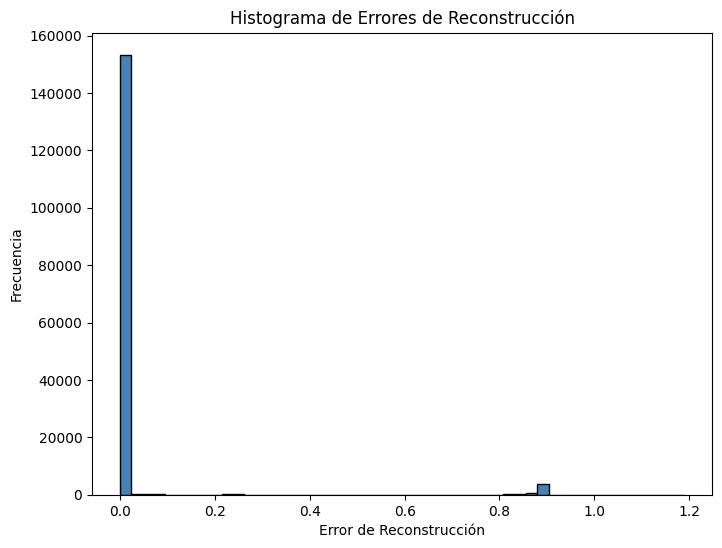

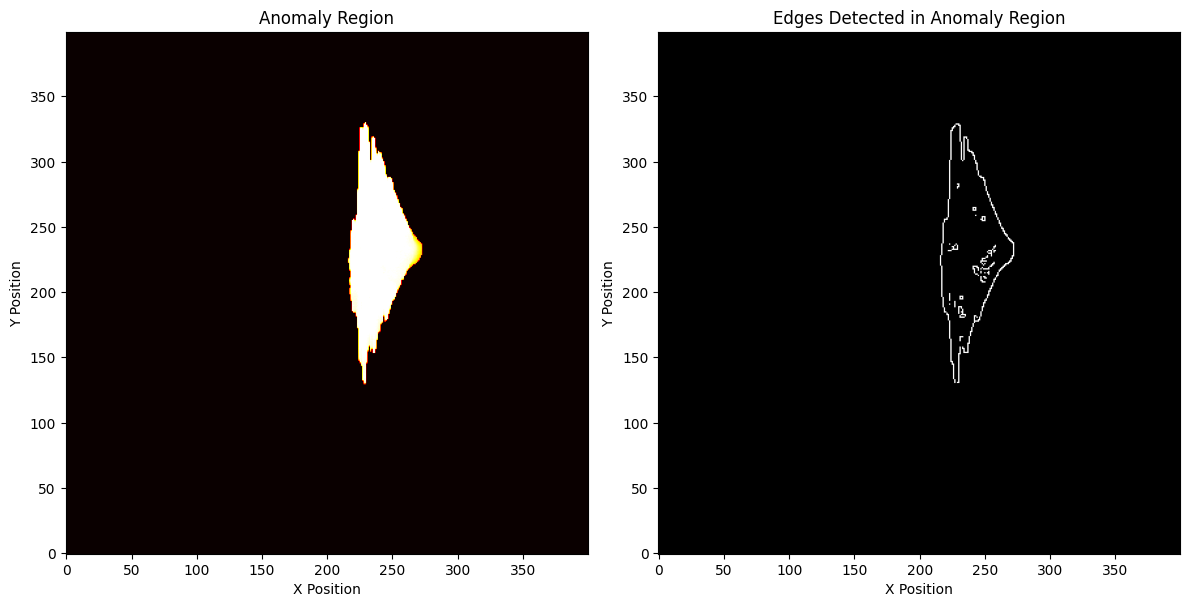

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MeanShift
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny

# Define the Encoder, Decoder, and ceVAE model classes
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)  # output_dim debe coincidir con el tamaño de x

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        h = torch.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))

class ceVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(ceVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Define the VAE loss function with separate reconstruction and KL divergence terms
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_x = torch.clamp(recon_x, min=0, max=1)
    x = torch.clamp(x, min=0, max=1)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

# Function to normalize features
def normalize_features(features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_normalized = scaler.fit_transform(features)
    return torch.tensor(features_normalized, dtype=torch.float32)

# Training function
def train_vae(model, dataloader, optimizer, epochs=100, beta=1):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0]
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset)}")

# Evaluation function for detecting anomalies
def evaluate_anomalies(model, features_tensor):
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(features_tensor)
        reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
        anomaly_threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
        anomalies = reconstruction_error > anomaly_threshold
    return anomalies

# Clustering and visualization functions
def cluster_and_visualize(anomalies, features, region_img2, bandwidth=0.2):
    mean_shift = MeanShift(bandwidth=bandwidth)
    anomaly_features = features[anomalies.numpy()]
    cluster_labels = mean_shift.fit_predict(anomaly_features)

    # Extract anomaly regions
    anomaly_mask = anomalies.numpy().reshape(region_img2.shape)
    anomaly_region = np.where(anomaly_mask, region_img2, 0)

    # Apply edge detection
    edges = canny(anomaly_region, sigma=1.0)

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(anomaly_region, cmap='hot', origin='lower')
    axs[0].set_title('Anomaly Region')
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Y Position')

    axs[1].imshow(edges, cmap='gray', origin='lower')
    axs[1].set_title('Edges Detected in Anomaly Region')
    axs[1].set_xlabel('X Position')
    axs[1].set_ylabel('Y Position')

    plt.tight_layout()
    plt.show()

# Main execution
input_dim = features.shape[1]
latent_dim = 10
output_dim = input_dim  # Asegúrate de que output_dim sea igual a input_dim para evitar errores de tamaño

# Normalización y creación de DataLoader
features_tensor = normalize_features(features)
dataset = TensorDataset(features_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Inicializar modelo y optimizador
model = ceVAE(input_dim, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entrenar el modelo
train_vae(model, dataloader, optimizer, epochs=100, beta=1)

# Evaluación para obtener recon_x y calcular reconstruction_error
model.eval()
with torch.no_grad():
    recon_x, _, _ = model(features_tensor)  # Obtener la reconstrucción

# Calcular el error de reconstrucción y graficar el histograma
reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error.numpy(), bins=50, color='steelblue', edgecolor='black')
plt.title('Histograma de Errores de Reconstrucción')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.show()

# Detectar anomalías y visualizar
anomalies = evaluate_anomalies(model, features_tensor)
cluster_and_visualize(anomalies, features, region_img2)


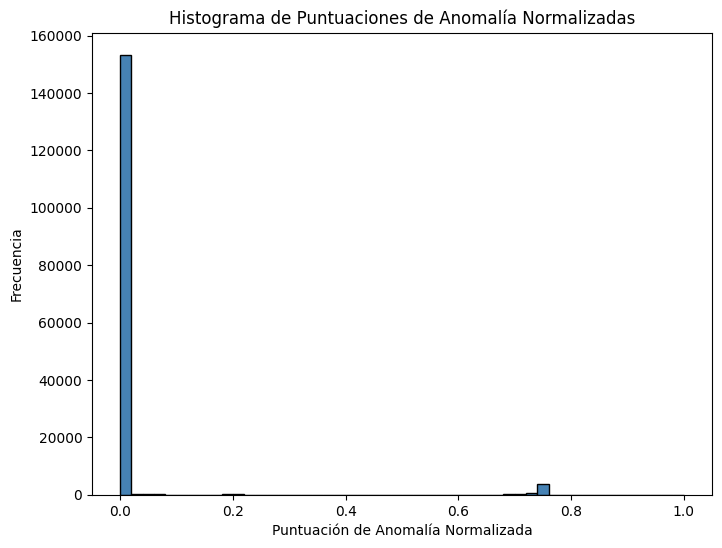

In [48]:
def plot_anomaly_score_histogram(reconstruction_error):
    """
    Genera un histograma de las puntuaciones de anomalía normalizadas.
    
    Args:
        reconstruction_error (torch.Tensor): Error de reconstrucción para cada muestra, obtenido en la fase de evaluación.
    """
    # Normalizar el error de reconstrucción
    normalized_score = (reconstruction_error - reconstruction_error.min()) / (reconstruction_error.max() - reconstruction_error.min())
    
    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(normalized_score.numpy(), bins=50, color='steelblue', edgecolor='black')
    plt.title('Histograma de Puntuaciones de Anomalía Normalizadas')
    plt.xlabel('Puntuación de Anomalía Normalizada')
    plt.ylabel('Frecuencia')
    plt.show()

# Ejecutar el gráfico después de la fase de evaluación
reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
plot_anomaly_score_histogram(reconstruction_error)


In [57]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Función para evaluar y obtener las anomalías
def evaluate_anomalies(model, features_tensor):
    """
    Evalúa el modelo para detectar anomalías basadas en el error de reconstrucción.
    
    Args:
        model (torch.nn.Module): Modelo ceVAE entrenado.
        features_tensor (torch.Tensor): Características normalizadas de entrada.
    
    Returns:
        torch.Tensor: Tensor booleano con True en los elementos anómalos.
    """
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(features_tensor)
        reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
        anomaly_threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
        anomalies = reconstruction_error > anomaly_threshold
    return anomalies.reshape(region_img2.shape)  # Ajusta el tamaño según region_img2

# Función para generar el gráfico de las regiones de anomalía
def plot_anomaly_regions(anomaly_mask, region_img2):
    """
    Genera un mapa de calor de las regiones de anomalías en la imagen solar.
    
    Args:
        anomaly_mask (np.array): Máscara de anomalías en forma de array 2D (mismo tamaño que `region_img2`).
        region_img2 (np.array): Imagen original de la región solar.
    """
    # Verificación de la forma de la máscara
    if anomaly_mask.shape != region_img2.shape:
        print("Error: La máscara de anomalías no coincide con el tamaño de la imagen.")
        return
    
    # Convertir la máscara a tipo binario si es necesario
    anomaly_mask = anomaly_mask.astype(np.uint8)

    # Crear contornos sobre las áreas anómalas usando OpenCV
    contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Número de contornos encontrados: {len(contours)}")  # Mensaje de depuración

    region_img2_with_boxes = region_img2.copy()
    
    # Dibujar rectángulos alrededor de los contornos
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(region_img2_with_boxes, (x, y), (255, 0, 0), 2)  # Rojo para cuadros delimitadores
    
    # Visualizar la imagen con las regiones de anomalías
    plt.figure(figsize=(8, 8))
    plt.imshow(region_img2_with_boxes, cmap='hot', origin='lower')
    plt.title('Regiones de Anomalías en la Imagen Solar')
    plt.axis('off')
    plt.show()

# Uso de las funciones
anomalies = evaluate_anomalies(model, features_tensor)
plot_anomaly_regions(anomalies.numpy().reshape(region_img2.shape), region_img2)


Número de contornos encontrados: 1


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt2'. Expected sequence length 2, got 3
>  - Can't parse 'pt2'. Expected sequence length 2, got 3
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


Puntuación de Anomalías por Imagen y Nivel de Píxel

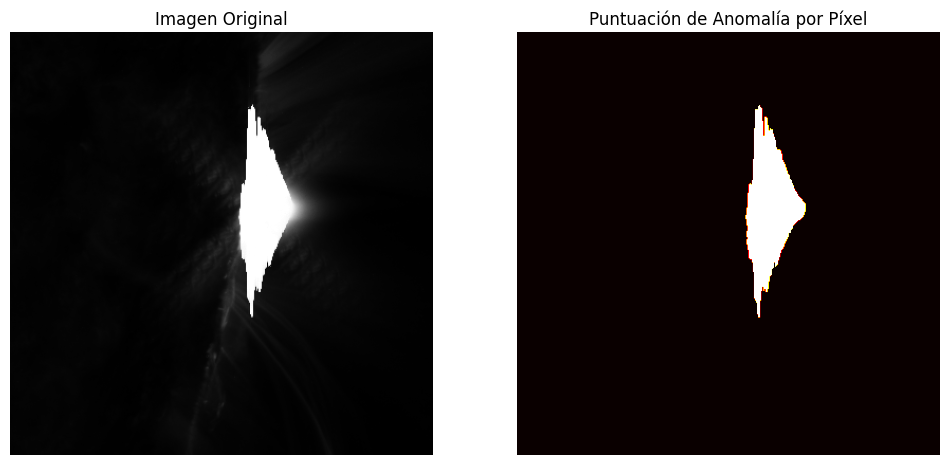

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Función para evaluar anomalías
def evaluate_anomalies(model, features_tensor):
    """
    Evalúa el modelo para detectar anomalías basadas en el error de reconstrucción.
    
    Args:
        model (torch.nn.Module): Modelo ceVAE entrenado.
        features_tensor (torch.Tensor): Características normalizadas de entrada.
    
    Returns:
        torch.Tensor: Tensor booleano con True en los elementos anómalos.
    """
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(features_tensor)
        reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
        anomaly_threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
        anomalies = reconstruction_error > anomaly_threshold
    return anomalies

# Función para visualizar las puntuaciones de anomalía a nivel de imagen y píxel
def plot_image_pixel_anomaly_scores(anomaly_mask, region_img2):
    """
    Genera gráficos que muestran las puntuaciones de anomalía a nivel de imagen y de píxel.
    
    Args:
        anomaly_mask (np.array): Máscara de anomalías para la imagen.
        region_img2 (np.array): Imagen original de la región solar.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Imagen original con regiones de anomalías resaltadas
    axs[0].imshow(region_img2, cmap='gray', origin='lower')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')
    
    # Puntuación de anomalías a nivel de píxel
    axs[1].imshow(anomaly_mask, cmap='hot', origin='lower')
    axs[1].set_title('Puntuación de Anomalía por Píxel')
    axs[1].axis('off')
    
    plt.show()

# Main execution without re-training
# Asegúrate de que 'features_tensor', 'model', y 'region_img2' estén cargados y disponibles
# Detectar anomalías basadas en el modelo ya entrenado
anomalies = evaluate_anomalies(model, features_tensor)

# Generar la máscara de anomalías en forma de imagen (asumimos que region_img2 tiene la misma dimensión que el reshape de features_tensor)
anomaly_mask = anomalies.numpy().reshape(region_img2.shape)

# Visualizar las puntuaciones de anomalía a nivel de imagen y de píxel
plot_image_pixel_anomaly_scores(anomaly_mask, region_img2)


. Interpolación en el Espacio Latente

In [51]:
def plot_latent_interpolation(model, start_point, end_point, steps=10):
    """
    Genera una interpolación en el espacio latente entre dos puntos.
    
    Args:
        model (ceVAE): Modelo ceVAE entrenado.
        start_point (torch.Tensor): Primer punto en el espacio latente.
        end_point (torch.Tensor): Último punto en el espacio latente.
        steps (int): Número de pasos de interpolación.
    """
    # Interpolación lineal en el espacio latente
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        z = start_point * (1 - alpha) + end_point * alpha
        recon = model.decoder(z)
        
        # Verificar el tamaño de salida del decodificador
        print(f"Shape de la salida del decodificador: {recon.shape}")
        
        # Si la salida tiene solo un elemento, no es adecuada para visualización de imágenes
        if recon.numel() == 1:
            print("La salida es un valor escalar y no puede visualizarse como una imagen.")
            return
        
        # Ajuste de visualización según el tamaño de la salida
        if recon.dim() == 1:
            output_shape = int(np.sqrt(recon.size(0)))  # Asumiendo una salida cuadrada si es 1D
            if output_shape ** 2 == recon.size(0):
                interpolated_images.append(recon.view(output_shape, output_shape).detach().numpy())
            else:
                print("La salida no puede ser transformada en una imagen cuadrada.")
                return
        elif recon.dim() == 2:
            interpolated_images.append(recon.detach().numpy())
        else:
            print("El decodificador devuelve una salida de forma inesperada.")
            return
    
    # Visualizar la interpolación
    fig, axs = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, img in enumerate(interpolated_images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.suptitle('Interpolación en el Espacio Latente')
    plt.show()

# Ejecutar interpolación después de obtener puntos de inicio y fin en el espacio latente
start_point, end_point = torch.randn(latent_dim), torch.randn(latent_dim)
plot_latent_interpolation(model, start_point, end_point)


Shape de la salida del decodificador: torch.Size([3])
La salida no puede ser transformada en una imagen cuadrada.


# Comparacion con el articulo nsupervised Anomaly Detection With Variational Autoencoders Applied to Full-Disk Solar Images

In [56]:
from astropy.io import fits
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Cargar la imagen FITS desde la ubicación proporcionada
fits_path = "Data/SDO_papper/aia.lev1_euv_12s.2014-11-25T124812Z.171.image_lev1.fits"
with fits.open(fits_path) as hdul:
    region_img2 = hdul[0].data

# Normalización de la imagen para que coincida con la escala de entrada del modelo
def normalize_features(features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_normalized = scaler.fit_transform(features)
    return torch.tensor(features_normalized, dtype=torch.float32)

# Asegurarse de que la imagen tenga el formato correcto
image_data_normalized = normalize_features(region_img2.reshape(-1, 1)).reshape(region_img2.shape)

# Convertir la imagen normalizada en un tensor adecuado para el modelo
image_tensor = torch.tensor(image_data_normalized, dtype=torch.float32).view(-1, region_img2.shape[0] * region_img2.shape[1])

# Función para evaluar y obtener las anomalías
def evaluate_anomalies(model, features_tensor):
    """
    Evalúa el modelo para detectar anomalías basadas en el error de reconstrucción.
    
    Args:
        model (torch.nn.Module): Modelo ceVAE entrenado.
        features_tensor (torch.Tensor): Características normalizadas de entrada.
    
    Returns:
        torch.Tensor: Tensor booleano con True en los elementos anómalos.
    """
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(features_tensor)
        reconstruction_error = ((features_tensor - recon_x) ** 2).sum(dim=1)
        anomaly_threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
        anomalies = reconstruction_error > anomaly_threshold
    return anomalies.reshape(region_img2.shape)  # Ajustar la forma de las anomalías para que coincida con la imagen

# Función para generar el gráfico de las regiones de anomalía
def plot_anomaly_regions(anomaly_mask, region_img2):
    """
    Genera un mapa de calor de las regiones de anomalías en la imagen solar.
    
    Args:
        anomaly_mask (np.array): Máscara de anomalías en forma de array 2D (mismo tamaño que `region_img2`).
        region_img2 (np.array): Imagen original de la región solar.
    """
    # Verificación de la forma de la máscara
    if anomaly_mask.shape != region_img2.shape:
        print("Error: La máscara de anomalías no coincide con el tamaño de la imagen.")
        return
    
    # Convertir la máscara a tipo binario si es necesario
    anomaly_mask = anomaly_mask.astype(np.uint8)

    # Crear contornos sobre las áreas anómalas usando OpenCV
    contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Número de contornos encontrados: {len(contours)}")  # Mensaje de depuración

    region_img2_with_boxes = region_img2.copy()
    
    # Dibujar rectángulos alrededor de los contornos
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(region_img2_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Rojo para cuadros delimitadores
    
    # Visualizar la imagen con las regiones de anomalías
    plt.figure(figsize=(8, 8))
    plt.imshow(region_img2_with_boxes, cmap='hot', origin='lower')
    plt.title('Regiones de Anomalías en la Imagen Solar')
    plt.axis('off')
    plt.show()

# Uso de las funciones
anomalies = evaluate_anomalies(model, image_tensor)
plot_anomaly_regions(anomalies.numpy().reshape(region_img2.shape), region_img2)


FileNotFoundError: [Errno 2] No such file or directory: 'Data/SDO_papper/aia.lev1_euv_12s.2014-11-25T124812Z.171.image_lev1.fits'

### 1. **Uso de un Enfoque No Supervisado**
   - **Propuesta del Artículo**: Utilizan un modelo ceVAE para identificar y localizar regiones anómalas en imágenes solares en ultravioleta extremo (EUV). Este enfoque es puramente no supervisado, lo cual evita la dependencia de etiquetas y permite que el modelo aprenda directamente de los datos sin sesgos.
   - **Posible Aplicación**: Implementar un modelo de autoencoder variacional en nuestro proyecto podría permitirnos detectar anomalías en regiones solares frías observadas en los datos de ALMA o SDO sin necesidad de etiquetas. Esto podría ayudarnos a identificar eventos raros o incluso desconocidos en los datos.

### 2. **Reducción de Dimensionalidad para Mejorar la Detección**
   - **Propuesta del Artículo**: El ceVAE aprende una representación de baja dimensión de las imágenes solares, lo que facilita la identificación de anomalías en las regiones más relevantes de las imágenes.
   - **Posible Aplicación**: Para mejorar la precisión y reducir el tiempo de cómputo en la detección de anomalías, podríamos explorar el uso de autoencoders para obtener una representación de baja dimensionalidad de las características de intensidad y gradientes en nuestras imágenes de regiones activas.

### 3. **Puntajes de Anomalía a Nivel de Imagen y de Pixel**
   - **Propuesta del Artículo**: Calculan puntajes de anomalía tanto a nivel de imagen como de pixel, permitiendo identificar tanto imágenes como regiones específicas que son anómalas.
   - **Posible Aplicación**: Implementar puntajes de anomalía por pixel podría ayudarnos a segmentar y visualizar anomalías directamente en las regiones de interés. Esto facilitaría la interpretación visual de áreas anómalas en las imágenes solares, especialmente útil para analizar cambios temporales en eventos solares.

### 4. **Filtrado Inteligente de Imágenes para el Monitoreo del Clima Espacial**
   - **Propuesta del Artículo**: Proponen el uso del modelo ceVAE como un sistema de monitoreo que filtra imágenes inusuales en tiempo real, con un enfoque de puntuación de 2 o 3 sigma para detectar imágenes anómalas en periodos de alta actividad solar.
   - **Posible Aplicación**: Este enfoque podría ser útil para priorizar y resaltar imágenes con anomalías significativas en nuestro proyecto, mejorando la eficiencia en el procesamiento de grandes volúmenes de datos solares y destacando posibles eventos relevantes para análisis en tiempo real.

### 5. **Control de Calidad y Reducción de Ruido en Anotaciones**
   - **Propuesta del Artículo**: El modelo puede utilizarse para detectar errores en las etiquetas existentes (como las anotaciones de HEK) y mejorar la precisión de las anotaciones mediante la comparación con otros métodos de contorno.
   - **Posible Aplicación**: Podríamos implementar un sistema similar para validar automáticamente nuestras anotaciones de eventos fríos y mejorar la consistencia de nuestras etiquetas. Esto también podría aplicarse para identificar artefactos o ruido en las observaciones y asegurarnos de que nuestras anomalías sean verdaderos eventos solares.

### Ideas Nuevas que Podríamos Proponer:
   - **Incorporación de Multi-Modalidad**: Usar datos adicionales (como mediciones magnéticas) junto con imágenes de intensidad podría ayudar a enriquecer las representaciones de anomalía.
   - **Uso de Modelos Híbridos**: Integrar modelos como Isolation Forest y ceVAE, donde el primero filtra y el segundo profundiza en la segmentación detallada de anomalías.
   - **Aplicación de Modelos para la Predicción de Eventos**: Usar las anomalías detectadas para predecir futuros eventos solares, aprovechando la alta correlación de actividad solar en periodos de rotación completa del sol.

----------------------------------------------------------------------------------------------------------------------

### 1. **Detección de Anomalías Usando Autoencoders Variacionales (ceVAE)**

#### Objetivo
Utilizar un autoencoder variacional de codificación de contexto (ceVAE) para detectar y localizar anomalías en nuestra imagen de SDO, basado en datos no etiquetados. Esto permite aprender representaciones latentes que capturan características esenciales sin sesgos preexistentes.

#### Pasos
   - **Preparación de los Datos**: Usaremos la imagen de SDO y los gradientes (X e Y) como entrada para el autoencoder, similar a lo que hemos realizado con el Isolation Forest.
   - **Entrenamiento del ceVAE**: Entrenar el modelo ceVAE con la imagen completa para que pueda aprender a reconstruir las regiones normales y detectar anomalías en las áreas donde la reconstrucción sea deficiente.
   - **Evaluación de Anomalías**: Generar un puntaje de anomalía en cada pixel comparando la imagen original con la reconstrucción generada por el ceVAE. Esto nos permitirá identificar áreas anómalas en la imagen con precisión de pixel.

---

### 2. **Reducción de Dimensionalidad y Representación de Características**

#### Objetivo
Reducir la dimensionalidad para mejorar la eficiencia computacional y optimizar la identificación de características anómalas.

#### Pasos
   - **Implementación de Autoencoder Convencional**: Utilizar un autoencoder simple para reducir la dimensionalidad de las características de intensidad y gradiente (X e Y) en un espacio latente compacto.
   - **Comparación de Anomalías en el Espacio Latente**: Al igual que en el ceVAE, calcular los puntajes de anomalía en este espacio latente y compararlos con los detectados por el Isolation Forest.
   - **Evaluación Visual de las Representaciones Latentes**: Visualizar las características latentes para comprobar cómo se agrupan los puntos normales y anómalos en el espacio reducido.

---

### 3. **Puntajes de Anomalía a Nivel de Imagen y Pixel**

#### Objetivo
Detectar anomalías tanto a nivel de pixel como en regiones completas, ayudando a priorizar imágenes de interés y entender la distribución de anomalías en la imagen solar.

#### Pasos
   - **Generación de Puntajes por Pixel**: Utilizar el Isolation Forest o ceVAE para calcular un puntaje de anomalía por cada pixel. Esto ya lo implementamos con el Isolation Forest, donde los pixels se etiquetan como normales o anomalías.
   - **Representación Gráfica de Puntajes por Pixel**: Crear un mapa de calor superpuesto a la imagen original, mostrando la intensidad de la anomalía en cada pixel para una fácil identificación visual de las áreas de interés.
   - **Identificación de Imágenes de Alta Actividad Solar**: Sumar los puntajes de anomalía en toda la imagen para obtener una puntuación total de anomalía. Esto ayudará a priorizar las imágenes de mayor interés para análisis adicionales.

---

### 4. **Filtrado Inteligente de Imágenes para Monitoreo del Clima Espacial**

#### Objetivo
Configurar un sistema de monitoreo en tiempo real que detecte eventos solares significativos en base a las anomalías detectadas, ayudando a los observatorios a priorizar la observación de eventos solares inusuales.

#### Pasos
   - **Implementación de un Umbral de Anomalía**: Utilizar una regla de desviación estándar (2 o 3 sigma) para resaltar las imágenes más anómalas en un conjunto de datos.
   - **Monitoreo y Alerta en Tiempo Real**: Configurar el sistema para que, cada vez que una imagen supere el umbral de anomalía, envíe una alerta, indicando que es un periodo de alta actividad solar.
   - **Pruebas en Series Temporales**: A partir de un conjunto de imágenes, analizar cómo cambia la actividad de anomalías a lo largo del tiempo, facilitando la detección de ciclos y patrones de alta actividad solar.

---

### 5. **Control de Calidad y Validación de Anotaciones**

#### Objetivo
Validar las anomalías detectadas y mejorar la precisión de nuestras etiquetas para reducir la presencia de ruido o artefactos.

#### Pasos
   - **Validación de Anomalías por Pixel**: Comparar las anomalías detectadas por ceVAE y Isolation Forest. Si ambos modelos coinciden en un área anómala, se puede confirmar con más seguridad que es una anomalía real.
   - **Segmentación y Mejora de Anotaciones**: Usar el modelo para etiquetar automáticamente las imágenes de forma consistente, evitando sesgos de observación humana.
   - **Revisión de Anotaciones Anteriores**: Utilizar el sistema para verificar etiquetas en imágenes ya anotadas, validando que las anomalías sean consistentes con los eventos solares reales.

---

### 6. **Implementación de Clustering y Detección de Bordes como Features Adicionales**

#### Objetivo
Utilizar clustering y detección de bordes para proporcionar una representación estructurada de las anomalías, ayudando a identificar la forma y distribución espacial de eventos solares anómalos.

#### Pasos
   - **Aplicación de Clustering con Mean Shift**: Como ya intentamos, este algoritmo nos permitirá agrupar las anomalías detectadas en clusters, destacando estructuras o patrones en las regiones anómalas.
   - **Aplicación del Filtro de Canny**: Detectar bordes en las imágenes solares y utilizarlos para mejorar la segmentación de las áreas de alta actividad. Esto ya lo implementamos y podríamos integrarlo en el análisis del Isolation Forest o ceVAE como un indicador visual de contornos anómalos.
   - **Visualización de Clusters y Bordes**: Crear una visualización final donde los clusters de anomalías se muestren con colores distintos, y los bordes detectados por el filtro de Canny estén superpuestos para una interpretación detallada de la actividad solar.




In [1]:
import sunpy.map

In [2]:
file1 = sunpy.map.Map("/home/alyonaivanova/personal/SOLAR/Data/multichannel_SDO_AIA/131.0Å/aia.lev1.131A_2020_09_01T00_00_06.62Z.image_lev1.fits")

In [5]:
file1.meta

MetaDict([('xtension': 'IMAGE')
('bitpix': '16')
('naxis': '2')
('naxis1': '4096')
('naxis2': '4096')
('pcount': '0')
('gcount': '1')
('bld_vers': 'V9R3X')
('lvl_num': '1.0')
('t_rec': '2020-09-01T00:00:08Z')
('trecstep': '1.0')
('trecepoc': '1977.01.01_00:00:00_TAI')
('trecroun': '1')
('origin': 'SDO/JSOC-SDP')
('date': '2020-09-05T01:30:08')
('telescop': 'SDO/AIA')
('instrume': 'AIA_1')
('date-obs': '2020-09-01T00:00:06.62')
('t_obs': '2020-09-01T00:00:08.07Z')
('camera': '1')
('img_type': 'LIGHT')
('exptime': '2.901304')
('expsdev': '7.7e-05')
('int_time': '3.15625')
('wavelnth': '131')
('waveunit': 'angstrom')
('wave_str': '131_THIN')
('fsn': '220241669')
('fid': '0')
('quallev0': '0')
('quality': '0')
('totvals': '16777216')
('datavals': '16777216')
('missvals': '0')
('percentd': '100.0')
('datamin': '-8')
('datamax': '545')
('datamedn': '2')
('datamean': '4.26')
('datarms': '6.01')
('dataskew': '3.09')
('datakurt': '24.73')
('datacent': '5.2')
('datap01': '-1.0')
('datap10': '1.0

In [ ]:
file1.meta["naxis"]

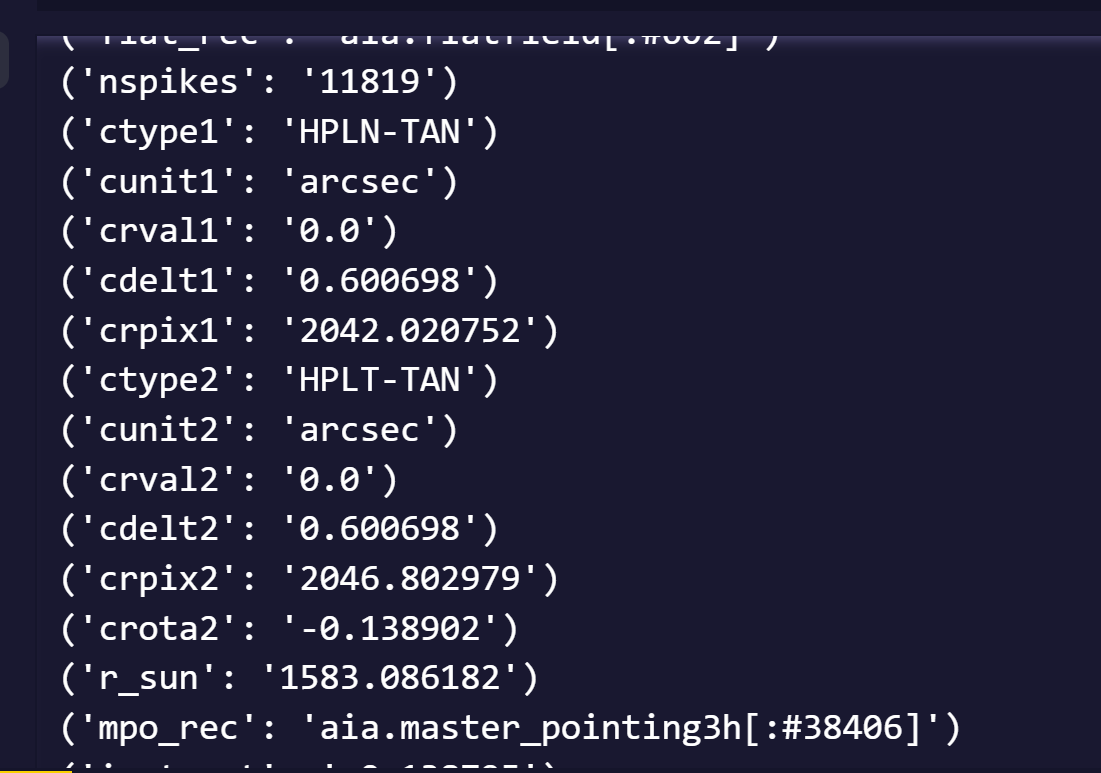